## Task : Predicting Employee Retention
Author : Gianmarco Mendiola Colan

Created on : 09/2021

Interpreter : Python 3.8

In [39]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import shap
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
# Tunning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randfloat
# Import linear ML algorithms
from sklearn.linear_model import LogisticRegression
# Import non-linear ML algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [70]:
# Read input
df = pd.read_csv('../QS/dataset.csv', delimiter=',')
df.rename(columns={'sales':'department'}, inplace=True)
df['top_performer'] = [1 if x>=0.8 else 0 for x in df['satisfaction_level']]

salary_levels = {'low':'1. low', 'medium':'2. medium', 'high':'3. high'}
df['salary'] = df['salary'].map(salary_levels)
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary,top_performer
0,0.38,0.53,2,157,3,0,1,0,sales,1. low,0
1,0.80,0.86,5,262,6,0,1,0,sales,2. medium,1
2,0.11,0.88,7,272,4,0,1,0,sales,2. medium,0
3,0.72,0.87,5,223,5,0,1,0,sales,1. low,0
4,0.37,0.52,2,159,3,0,1,0,sales,1. low,0


In [73]:
# Label encoding
le = preprocessing.LabelEncoder()
col_to_encode = ['salary', 'department']
for i in col_to_encode:
    new_col_name = i+'_2'
    df[new_col_name] = le.fit_transform(df[i])
df.sample(3)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary,top_performer,salary_2,department_2
5719,0.78,1.00,4,154,2,0,0,0,IT,1. low,0,0,0
14914,0.40,0.49,2,144,3,0,1,0,support,1. low,0,0,8
4472,0.60,0.59,3,172,3,0,0,0,technical,2. medium,0,1,9


In [75]:
# Feature selection
final_feat = ['satisfaction_level', 'last_evaluation', 'number_project',
                     'average_montly_hours', 'time_spend_company', 'Work_accident',
                     'promotion_last_5years', 'salary_2', 'department_2']

corr_feat = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'Work_accident',
       'time_spend_company','salary_2', 'promotion_last_5years', 'left']


x_trainning, y_trainning = df[final_feat], df['left']
X_train, X_test, y_train, y_test = train_test_split(x_trainning, y_trainning, test_size=0.3, random_state=69)

In [7]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   promotion_last_5years  14999 non-null  int64  
 7   salary_2               14999 non-null  int32  
 8   department_2           14999 non-null  int32  
dtypes: float64(2), int32(2), int64(5)
memory usage: 937.6 KB


## Corr


In [71]:
df.loc[df['top_performer']==1]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary,top_performer
1,0.80,0.86,5,262,6,0,1,0,sales,2. medium,1
7,0.92,0.85,5,259,5,0,1,0,sales,1. low,1
8,0.89,1.00,5,224,5,0,1,0,sales,1. low,1
12,0.84,0.92,4,234,5,0,1,0,sales,1. low,1
25,0.89,0.92,5,242,5,0,1,0,sales,1. low,1
...,...,...,...,...,...,...,...,...,...,...,...
14977,0.81,0.85,4,251,6,0,1,0,hr,2. medium,1
14985,0.91,0.99,5,254,5,0,1,0,technical,2. medium,1
14986,0.85,0.85,4,247,6,0,1,0,technical,1. low,1
14987,0.90,0.70,5,206,4,0,1,0,technical,1. low,1


<AxesSubplot:>

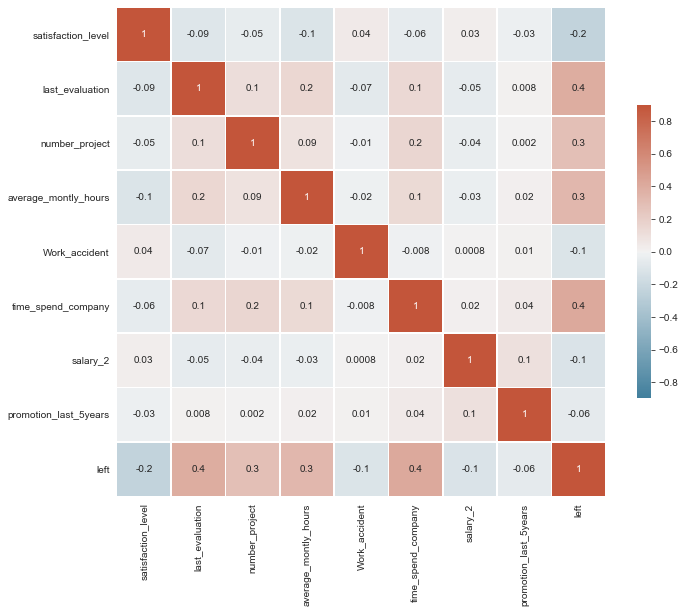

In [76]:
# Correlation
df_corr=df.loc[df['top_performer']==1]
corr = df_corr[corr_feat].corr()

mask = np.triu(corr)
f, ax = plt.subplots(figsize=(11, 9))
# Palette
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Heatmap
sns.heatmap(corr, cmap=cmap, vmin=-.9, vmax=.9, center=0,annot=True, fmt='.1g',
            square=True, linewidths=.5, cbar_kws={"shrink": .6})

In [19]:
# Cross validation
cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=2, random_state=420)
results = []
model_names = []
all_models = []
all_models.append(('LR', LogisticRegression(max_iter=500)))
all_models.append(('NB', GaussianNB()))
all_models.append(('SVM', SVC()))
all_models.append(('KNN', KNeighborsClassifier()))
all_models.append(('XGB', XGBClassifier()))

# Running the tests
for name, model in all_models:
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    results.append(scores)
    model_names.append(name)
    print(name, ':  ', 'Mean =  ', scores.mean(), '  ', 'STD =   ', scores.std())

LR :   Mean =   0.8177549033403021    STD =    0.007709393909746849
NB :   Mean =   0.8489796135261232    STD =    0.005596736189924426
SVM :   Mean =   0.803754738228814    STD =    0.007681120357180777
KNN :   Mean =   0.9647200618580044    STD =    0.005175508122361828
[10:53:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Start

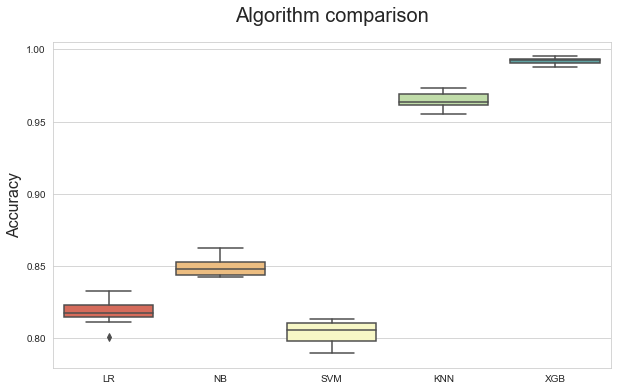

In [79]:
df_results = pd.DataFrame(np.transpose(results),columns=model_names)

# Visualise CV results
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.boxplot(data=df_results, palette='Spectral')
plt.title('Algorithm comparison', fontsize=20, pad=20)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

#### Hyperparameter tunning

In [21]:
clf_xgb=XGBClassifier(objective='binary:logistic')

param_dist = {'n_estimators': sp_randint(20,100),
              'learning_rate': sp_randfloat(0.01, 0.59),
              'subsample': sp_randfloat(0.3, 0.6),
              'max_depth': [3, 4, 5],
              'colsample_bytree': sp_randfloat(0.5, 0.4),
              'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 5
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=420)

clf = RandomizedSearchCV(clf_xgb,
                         param_distributions=param_dist,
                         cv=cv, 
                         n_iter=5,
                         scoring='roc_auc',
                         error_score=0,
                         verbose=3,
                         n_jobs=-1)
clf.fit(X_train,y_train)

Fitting 20 folds for each of 5 candidates, totalling 100 fits
[10:54:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=420),
                   error_score=0,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None...
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002536F192100>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002536F292D30>,
                       

0.9917098728388777


<Figure size 576x360 with 0 Axes>

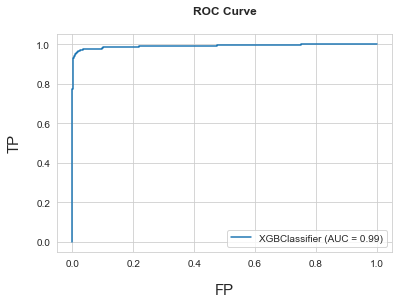

In [22]:
# ROC curve from best estimators
plt.figure(figsize=(8, 5))
print(roc_auc_score(y_test,clf.best_estimator_.predict_proba(X_test)[:, 1]))
metrics.plot_roc_curve(clf.best_estimator_, X_test, y_test)
plt.title('ROC Curve', pad=20, fontweight='bold')
plt.xlabel('FP', labelpad=15, fontsize=15)
plt.ylabel('TP', labelpad=15, fontsize=15)
plt.show()

#### Variables' model influence

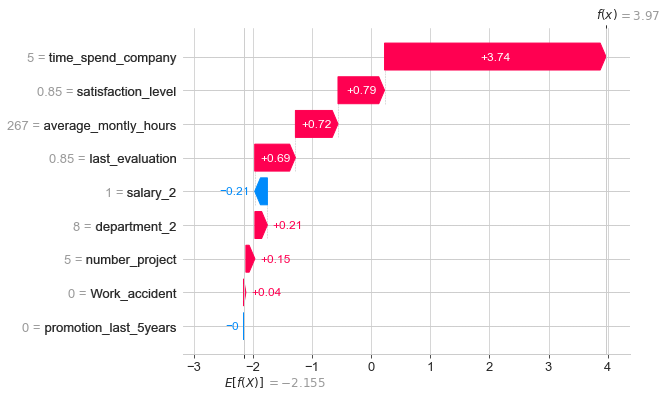

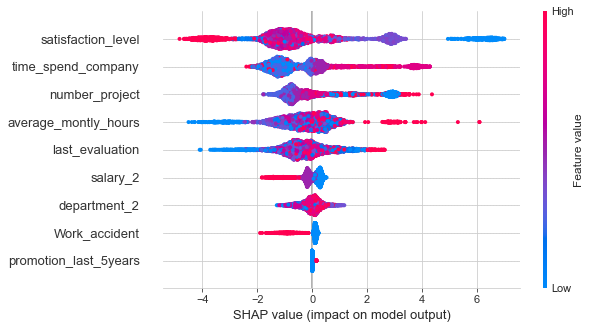

In [40]:
# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(best)
shap_values = explainer(X_test)

# Visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])
shap.plots.beeswarm(shap_values)

In [37]:
from sklearn.metrics import f1_score, precision_score, recall_score

best = clf.best_estimator_
pred_test = best.predict(X_test)
print(f1_score(y_test, pred_test))
print(precision_score(y_test, pred_test))
print(recall_score(y_test, pred_test))

0.9574074074074074
0.9745523091423186
0.9408553230209281


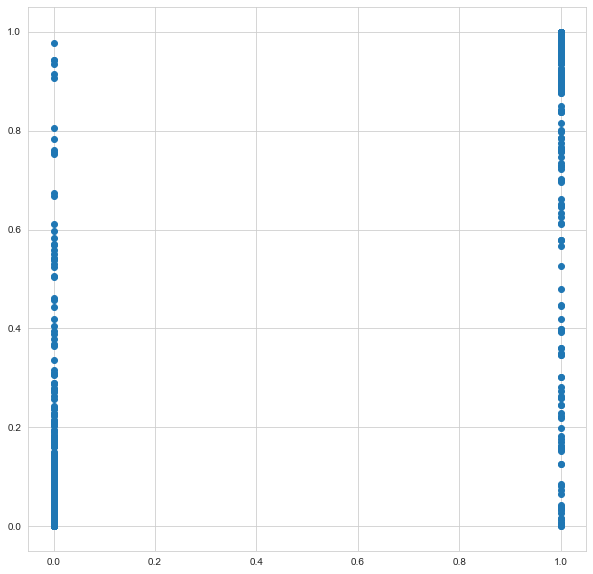

In [38]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, clf.best_estimator_.predict_proba(X_test)[:,1])

#### Prediction

In [45]:
# Using best estimator to predict
df_pred = x_trainning.copy()
df_pred['left_real'], df_pred['pred_proba'], df_pred['pred_bin'] = y_trainning, clf.best_estimator_.predict_proba(x_trainning)[:,1], clf.best_estimator_.predict(x_trainning),
df_pred['top_performer']= ['1' if x>=0.8 else '0' for x in df_pred['satisfaction_level']]

In [77]:
# Export results
df_pred.to_csv('QS_res_prob_final2.csv')

#### Validating feature distribution

In [52]:
def distribution_data(columns_na, data):
    for idx, item in enumerate(columns_na):
        sns.set_style(style='dark')
        fig, ax = plt.subplots(1, 2, sharex=False, gridspec_kw={"width_ratios": (1, 0.4)},
                               figsize=(15, 6))
        sns.histplot(data[item], ax=ax[0], stat="count",
                     label='skewness:{:.2f}'.format(data[item].skew()), kde=True)
        sns.boxplot(y=data[item], ax=ax[1])
        ax[0].legend()
        ax[0].grid()
        ax[1].grid()
        plt.show()

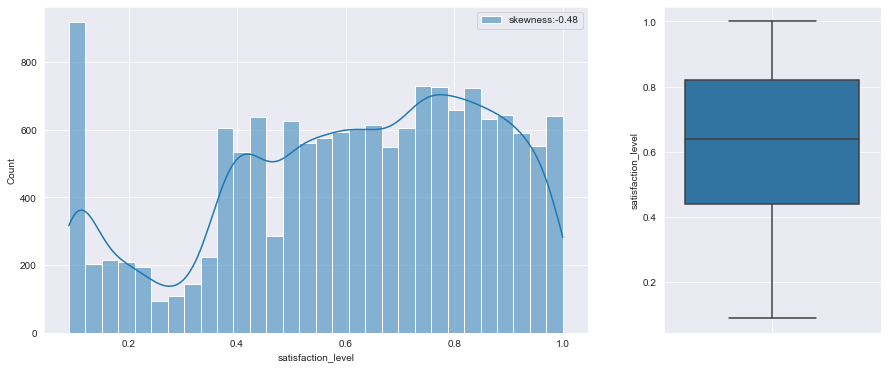

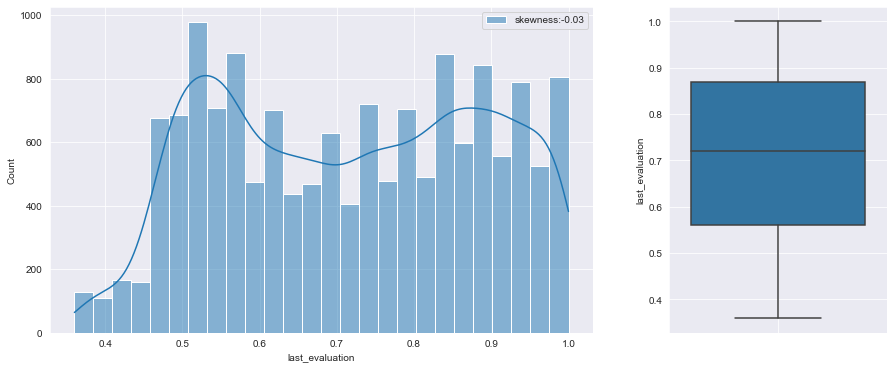

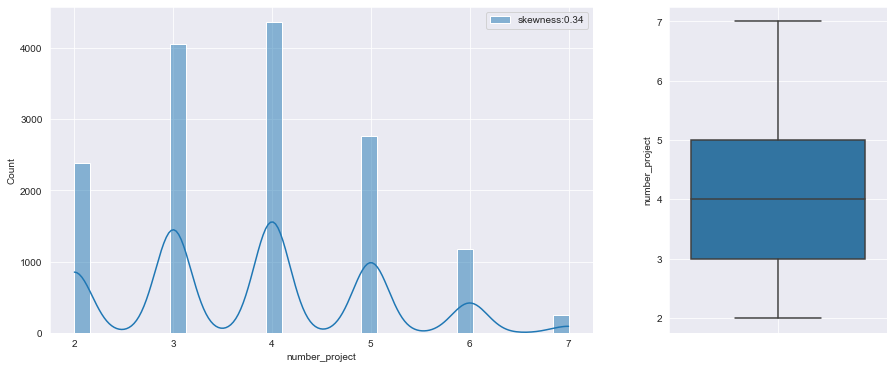

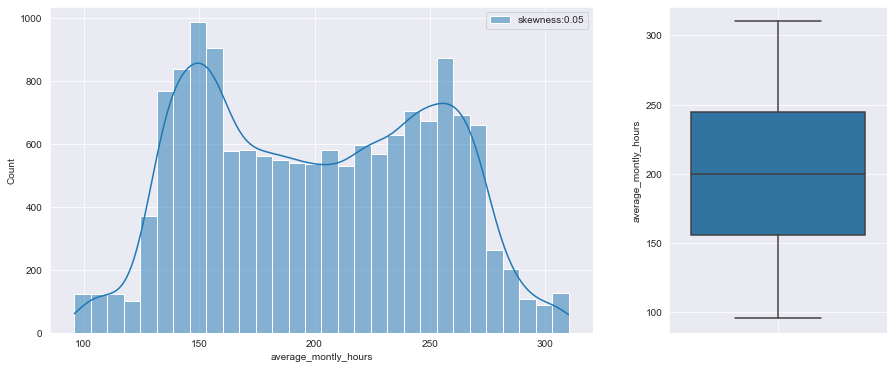

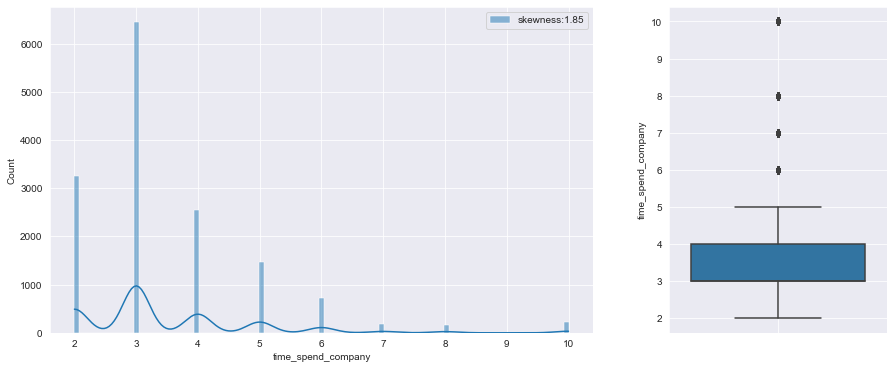

In [54]:
features = ['satisfaction_level', 'last_evaluation', 'number_project',
            'average_montly_hours', 'time_spend_company']
distribution_data(features, df)